In [4]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jul 10 10:00:25 2024

@author: sdd380
"""
import os
# Print the current working directory
cwd = os.getcwd()
if cwd.endswith('SOM_package'):
    print('Current working directory is already set to the package directory')
else:
    os.chdir('../')
    os.chdir(cwd + '/SOM_package')
from som_data_struct import som_data_struct
from som_normalize import som_normalize
from som_make import som_make
from som_bmus import som_bmus
from som_ind2sub import som_ind2sub
from som_denormalize import som_denormalize
from reader import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import copy
import numpy as np
from sklearn.cluster import KMeans
import math


Current working directory is already set to the package directory


Determining map size...
 sTopol first round done
Map size [44, 30]
Initialization...
 sTopol first round done
Training using batch algorithm...
Rough training phase...
Training: 1 / 4 s

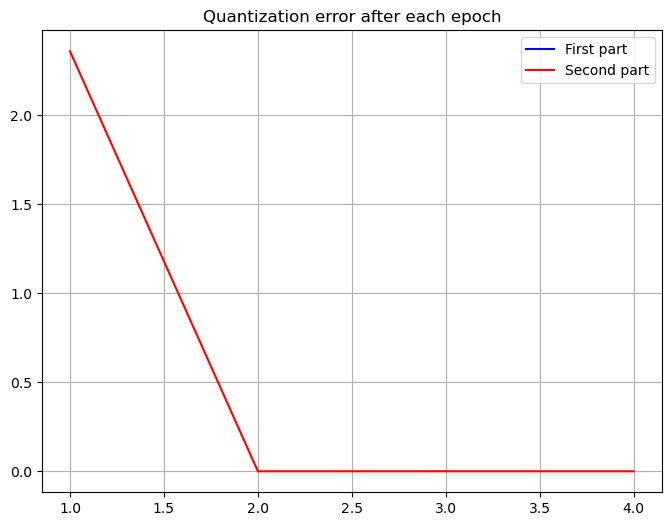

Training: 2 / 4 s

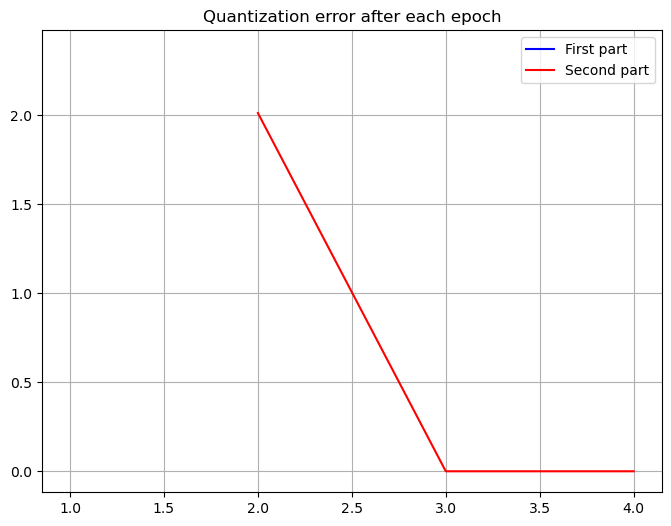

Training: 3 / 5 s

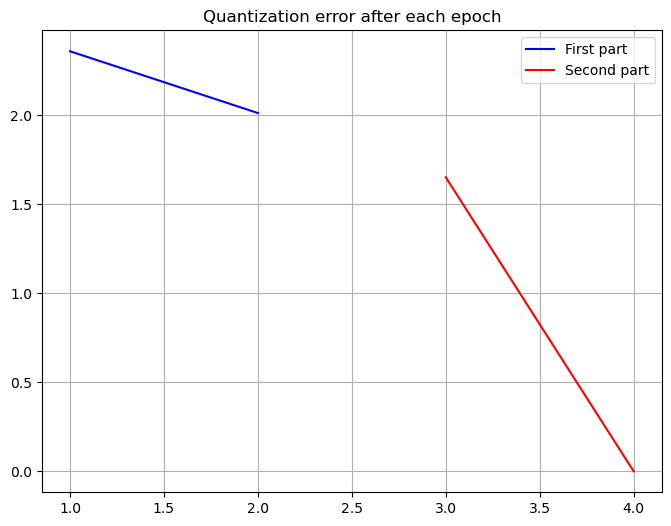

Training: 5 / 5 s

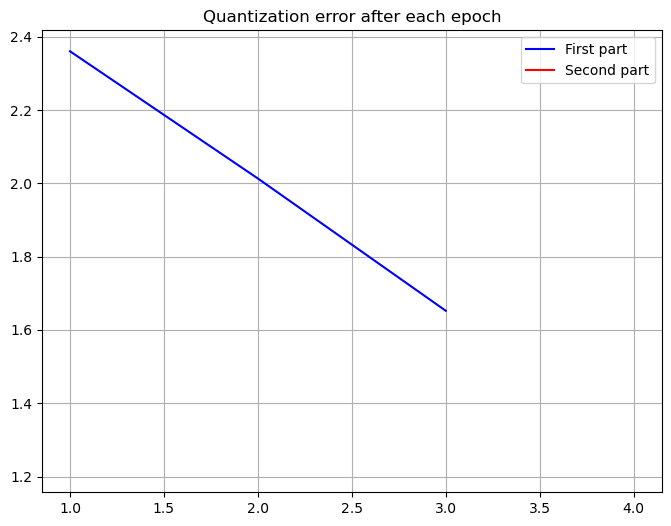



finetuning phase...
Training: 1 / 4 s

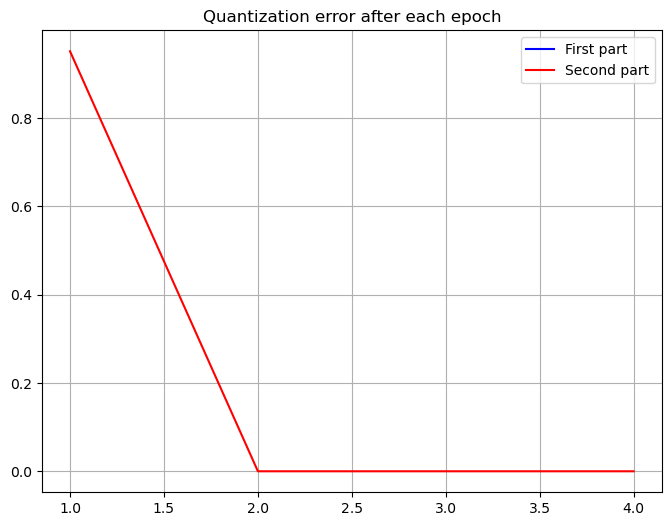

Training: 2 / 4 s

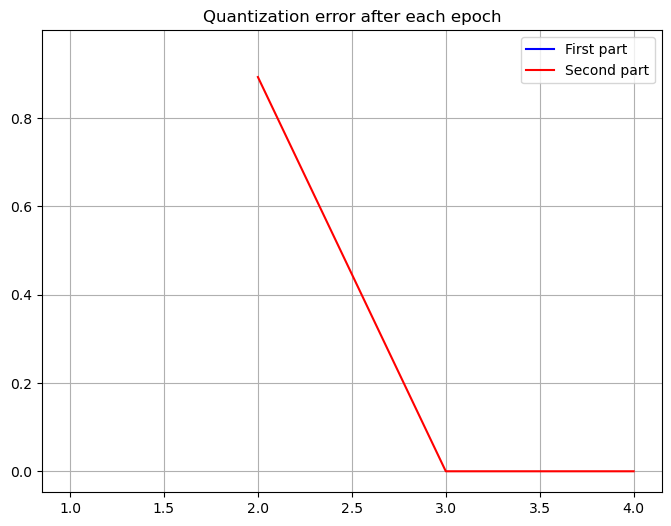

Training: 3 / 4 s

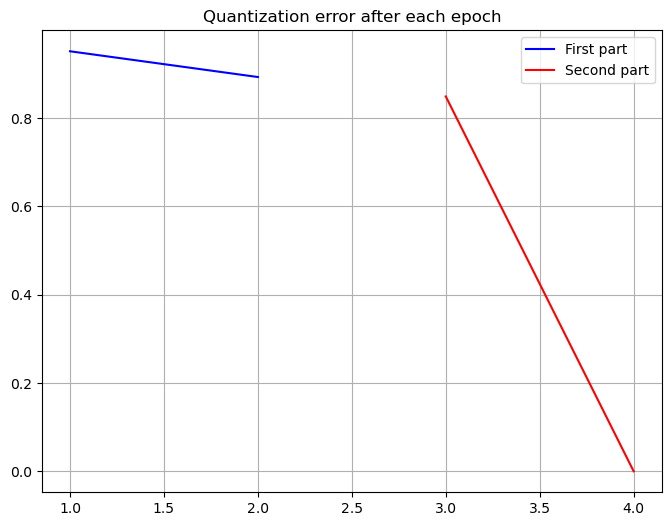

Training: 5 / 5 s

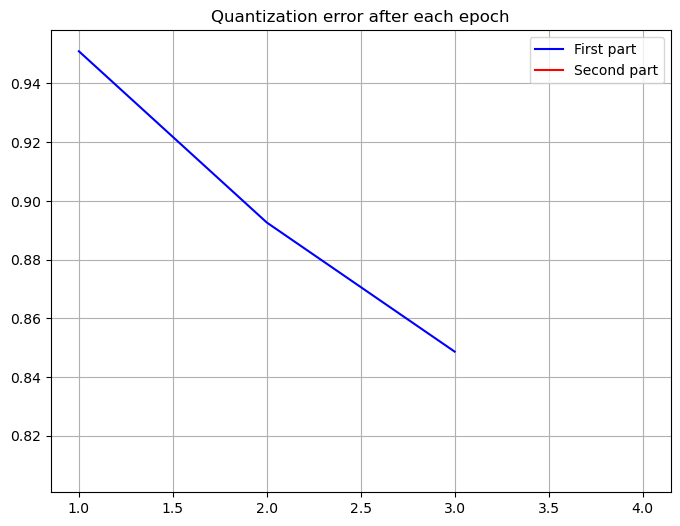



Final quantization error: 0.767
Final topographic error:  0.150


In [15]:
def read_headers(filename):
    '''just a test'''
    with open(filename, 'r') as f:
        headers = f.readline().strip().split(',')
    return headers

def read_data(filename):
    return np.loadtxt(filename, delimiter=',', skiprows=1)

## define dataset
filename = 'walking.csv'
filename_test = 'running.csv'

# Read data
headers = read_headers(filename)
data = read_data(filename)
#data = data[:math.ceil(len(data)/8)]

# create train and test structures
sData = som_data_struct(data.copy())
sData_copy = copy.deepcopy(sData)

test_data = read_data(filename_test)

#test_data = test_data[:math.ceil(len(test_data)/8)]

sTest = som_data_struct(test_data.copy())
sTest['comp_names'] = headers
sTest_copy = copy.deepcopy(sTest)

## Normalize the Data
plotdata = sData['data'].copy()
sData_norm = som_normalize(sData_copy, 'var')

plotdata_test = sTest['data'].copy()
sTest_norm = som_normalize(sTest_copy, 'var')
sTest_norm_copy = copy.deepcopy(sTest_norm)



## Train the SOM
sMap = som_make(sData_norm, *['lattice', 'shape', 'training', 'mapsize'],**{'lattice':'rect', 'shape':'sheet', 'training': 'long', 'mapsize': 'large'})

sMap['comp_names'] = headers


In [16]:
## Find best-matching units
Traj_train, Qerrs_train = som_bmus(sMap, sData_norm, 'all')
Traj_train_coord = som_ind2sub(sMap, Traj_train[:,0])
Traj_train_coord = np.concatenate((Traj_train_coord, Qerrs_train[:, [0]]), axis=1)
line1 = np.concatenate((sMap['topol']['msize'], [0]))

## SOM Testing
Traj_test, Qerrs_test = som_bmus(sMap, sTest_norm_copy, 'all')
Traj_test_coord = som_ind2sub(sMap, Traj_test[:,0])
Traj_test_coord = np.concatenate((Traj_test_coord, Qerrs_test[:, [0]]), axis=1)



In [17]:


## Denormalize the weight vectors
M = som_denormalize(sMap['codebook'].copy(), *[sMap])

Traj_train, Qerrs_train = som_bmus(M, plotdata.copy(), 'all')
Traj_train_coord = som_ind2sub(sMap, Traj_train[:,0])
Traj_train_coord = np.concatenate((Traj_train_coord, Qerrs_train[:, [0]]), axis=1)

Traj_test, Qerrs_test = som_bmus(M, plotdata_test.copy(), 'all')
Traj_test_coord = som_ind2sub(sMap, Traj_test[:,0])
Traj_test_coord = np.concatenate((Traj_test_coord, Qerrs_test[:, [0]]), axis=1)


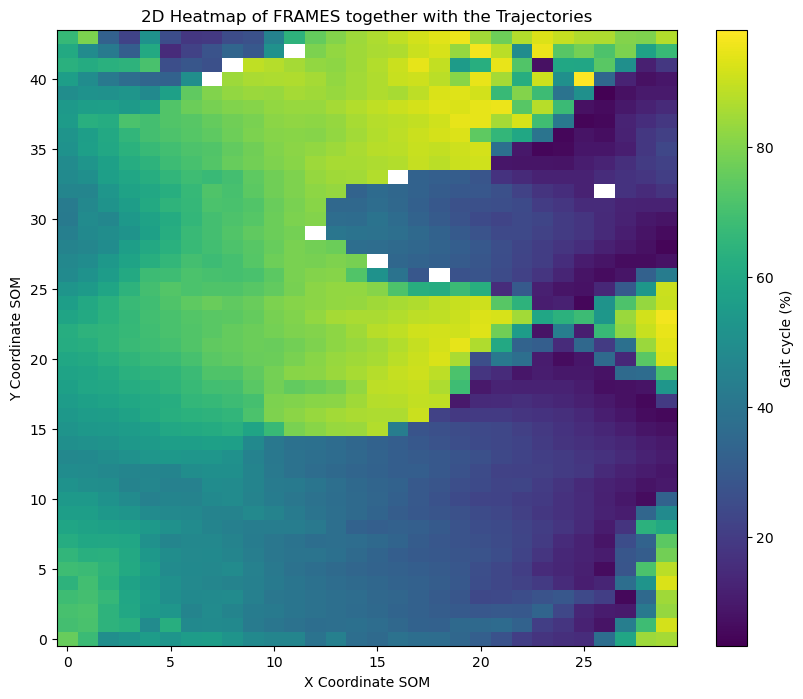

In [18]:
## index all input vectors assigned to one neuron
# find the lines that hit each neuron
index = [[None for _ in range(line1[1])] for _ in range(line1[0])]

# Iterate over t and q using nested loops
for t in range(0, line1[1]):
    for q in range(0, line1[0]):
        index[q][t] = np.where((Traj_train_coord[:, 0] == q) & (Traj_train_coord[:, 1] == t))[0]


# Compute average Frame number per neuron
# Flatten index using list comprehension
index_reQE = [item for sublist in index for item in sublist]

integer_division = []

for i in range(30,101):
    if len(plotdata) % i == 0:
        integer_division.append(i)
integer_division[-1]

# Number of frames (t)
num_repeats = len(plotdata) // integer_division[-2]

## Create a linearly spaced vector from 1 to 101
frame = np.linspace(1, 101, 101)
FRAMES = np.tile(frame, (num_repeats, 1)).flatten()
FRAMES = FRAMES.reshape(-1, 1)

FRAMES_SOM1 = np.zeros((len(M), 1))
for r in range(len(M)):
    FRAMES_SOM1[r, 0] = np.mean(FRAMES[index_reQE[r]])

FRAMES_re = FRAMES_SOM1.reshape(line1[0], line1[1])

extent = [0, FRAMES_re.shape[0], 0, FRAMES_re.shape[1]]

plt.figure(figsize=(10, 8))
plt.imshow(FRAMES_re, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Gait cycle (%)')
plt.xlabel('X Coordinate SOM')
plt.ylabel('Y Coordinate SOM')
plt.title('2D Heatmap of FRAMES together with the Trajectories')
breakpoint()


MEAN_train range: X(12.0 to 26.0), Y(3.0 to 26.0)
MEAN_test range: X(20.0 to 36.0), Y(1.0 to 29.0)
FRAMES_re shape: (44, 30)


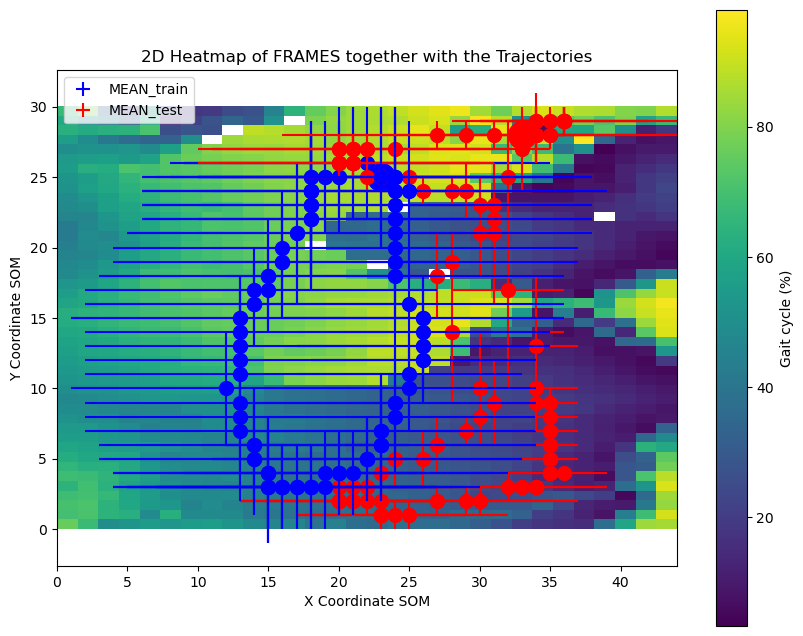

In [19]:
## EXPLORE THE MAP
x_train = np.reshape(Traj_train_coord[:, 0], (101, -1), order='F')
y_train = np.reshape(Traj_train_coord[:, 1], (101, -1), order='F') 
MEAN_train = np.column_stack((np.round(np.mean(x_train, axis=1)), np.round(np.mean(y_train, axis=1))))
STD_train = np.column_stack((np.round(np.std(x_train, axis=1)), np.round(np.std(y_train, axis=1))))

x_test = np.reshape(Traj_test_coord[:, 0], (101, -1), order='F')
y_test = np.reshape(Traj_test_coord[:, 1], (101, -1), order='F')
MEAN_test = np.column_stack((np.round(np.mean(x_test, axis=1)), np.round(np.mean(y_test, axis=1))))
STD_test = np.column_stack((np.round(np.std(x_test, axis=1)), np.round(np.std(y_test, axis=1))))



marker_sizes = np.ones(101) * 10  # Initialize all markers to size 10
marker_sizes[0] = 20  # Make the first marker larger

print(f"MEAN_train range: X({MEAN_train[:, 0].min()} to {MEAN_train[:, 0].max()}), Y({MEAN_train[:, 1].min()} to {MEAN_train[:, 1].max()})")
print(f"MEAN_test range: X({MEAN_test[:, 0].min()} to {MEAN_test[:, 0].max()}), Y({MEAN_test[:, 1].min()} to {MEAN_test[:, 1].max()})")
print(f"FRAMES_re shape: {FRAMES_re.shape}")

# Define the extent based on the actual data ranges
extent = [0, FRAMES_re.shape[0], 0, FRAMES_re.shape[1]]

plt.figure(figsize=(10, 8))
plt.imshow(FRAMES_re, aspect='auto', cmap='viridis', origin='lower', extent=extent)
plt.colorbar(label='Gait cycle (%)')
plt.xlabel('X Coordinate SOM')
plt.ylabel('Y Coordinate SOM')
plt.title('2D Heatmap of FRAMES together with the Trajectories')

# Plot MEAN_train and MEAN_test with error bars
for i in range(101):
    if i == 0:
        plt.errorbar(MEAN_train[i, 0], MEAN_train[i, 1], xerr=STD_train[i, 0], yerr=STD_train[i, 1], fmt='none', ecolor='b', label='MEAN_train')
        plt.errorbar(MEAN_test[i, 0], MEAN_test[i, 1], xerr=STD_test[i, 0], yerr=STD_test[i, 1], fmt='none', ecolor='r', label='MEAN_test')
        plt.plot(MEAN_train[i, 0], MEAN_train[i, 1], 'bo', markersize=marker_sizes[i])
        plt.plot(MEAN_test[i, 0], MEAN_test[i, 1], 'ro', markersize=marker_sizes[i])
    else:
        plt.errorbar(MEAN_train[i, 0], MEAN_train[i, 1], xerr=STD_train[i, 0], yerr=STD_train[i, 1], fmt='none', ecolor='b')
        plt.errorbar(MEAN_test[i, 0], MEAN_test[i, 1], xerr=STD_test[i, 0], yerr=STD_test[i, 1], fmt='none', ecolor='r')
        plt.plot(MEAN_train[i, 0], MEAN_train[i, 1], 'bo', markersize=marker_sizes[i])
        plt.plot(MEAN_test[i, 0], MEAN_test[i, 1], 'ro', markersize=marker_sizes[i])

# Set aspect ratio to be equal
plt.gca().set_aspect('equal', adjustable='box')

plt.legend()
plt.show()
breakpoint()

In [ ]:


## MOVEMENT DEVIATION PROFILE
# here the aim is to find the difference in Quantization Errors of the train and the test set
# relative to the SOM. These errors are then compared and illustrated into the so-called Movement 
# Deviation Profile (MDP)

# Reshape the first column of Traj_train
error_train = np.reshape(Traj_train_coord[:, 2], (101, -1), order='F')
MEAN_error_train = np.mean(error_train,axis=1)
STD_error_train = np.std(error_train, axis=1)


error_test = np.reshape(Traj_test_coord[:, 2], (101, -1), order='F')
MEAN_error_test = np.mean(error_test,axis=1)
STD_error_test = np.std(error_test, axis=1)

x = np.arange(1, 102)
y = STD_error_train
# Create the plot
plt.figure()
p1, = plt.plot(x, MEAN_error_train, 'k', linewidth=4, label='train Mean')
plt.fill_between(x, MEAN_error_train - y , MEAN_error_train + y, color=[0.6, 0.7, 0.8], alpha=0.2)
p2, = plt.plot(x, MEAN_error_test, 'r', label='test_MEAN')

plt.xlim([1, 101])
plt.xlabel('Gait Cycle (%)')
plt.ylabel('Quantization Error')
plt.legend()

plt.show()

breakpoint()

### CLUSTER the data based on the bmus
data1 = np.reshape(Traj_train_coord[:,0:3],(684, 101,3))
data2 = np.reshape(Traj_test_coord[:,0:3],(168, 101,3))

# Combine data along the first axis (vertical concatenation)
combined_data = np.concatenate((data1, data2), axis=0)

# Reshape data for clustering
flattened_data = combined_data.reshape(combined_data.shape[0], -1)

# Initialize K-means model
kmeans = KMeans(n_clusters=2, random_state=0)

# Fit K-means model to flattened data
kmeans.fit(flattened_data)

# Get cluster labels
cluster_labels = kmeans.labels_

# Separate indices of data1 and data2
num_data1 = data1.shape[0]
num_data2 = data2.shape[0]

# Create arrays to store indices of data1 and data2 in each cluster
data1_clusters = np.zeros(num_data1, dtype=int)  # Array to store cluster labels for data1
data2_clusters = np.zeros(num_data2, dtype=int)  # Array to store cluster labels for data2

# Assign cluster labels to data1
data1_clusters[cluster_labels[:num_data1] == 0] = 1  # Assign cluster 1 to trajectories in data1
data1_clusters[cluster_labels[:num_data1] == 1] = 2  # Assign cluster 2 to trajectories in data1

# Assign cluster labels to data2
data2_clusters[cluster_labels[num_data1:] == 0] = 1  # Assign cluster 1 to trajectories in data2
data2_clusters[cluster_labels[num_data1:] == 1] = 2  # Assign cluster 2 to trajectories in data2

# Combine the cluster labels into a single array
cluster_assignment = np.concatenate((data1_clusters, data2_clusters))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot data1 trajectories
for i in range(num_data1):
    if cluster_assignment[i] == 1:
        ax.plot(data1[i, :, 0], data1[i, :, 1], data1[i, :, 2], color='blue', alpha=0.5, label='Cluster 1' if i == 0 else '')
    elif cluster_assignment[i] == 2:
        ax.plot(data1[i, :, 0], data1[i, :, 1], data1[i, :, 2], color='red', alpha=0.5, label='Cluster 2' if i == 0 else '')

# Plot data2 trajectories
for i in range(num_data2):
    index = i + num_data1
    if cluster_assignment[index] == 1:
        ax.plot(data2[i, :, 0], data2[i, :, 1], data2[i, :, 2], color='red', alpha=0.5, label='Cluster 2' if i == 0 else '')
    elif cluster_assignment[index] == 2:
        ax.plot(data2[i, :, 0], data2[i, :, 1], data2[i, :, 2], color='red', alpha=0.5, label='Cluster 2' if i == 0 else '')

plt.title('3D Clustered Trajectories')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Quantization Error')
plt.legend()
plt.grid(True)
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys())
plt.show()

# Print the cluster assignments (just for demonstration)
print("Cluster assignments:")
for i in range(len(cluster_assignment)):
    if i < num_data1:
        print(f"Data1 slice {i} is in Cluster {cluster_assignment[i]}")
    else:
        print(f"Data2 slice {i - num_data1} is in Cluster {cluster_assignment[i]}")
